In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import time
from skopt import gp_minimize
from skopt.space import Real, Integer
from tqdm import tqdm

<h2 align="center"><strong>Implementación de un Modelo kMC para la Simulación de Procesos de Adsorción de Contaminantes Metálicos</strong></h2>



### **Creación del modelo**

In [3]:
class KineticMonteCarlo:
    def __init__(self, lattice_size, T, e_ads, e_diff, e_int_abs, time_array, time_factor):
        self.lattice_size = lattice_size
        self.lattice = np.zeros((lattice_size, lattice_size))
        self.T = T
        self.e_ads = e_ads
        self.e_diff = e_diff
        self.e_int_abs = e_int_abs
        self.k_b = 8.617e-5
        self.h = 4.136e-15
        self.k_0 = 5
        self.factor = time_factor
        self.time = time_array[0]
        self.time_array = time_array
        self.occupancy = {t: None for t in self.time_array}
        self.events_count = {"adsorption": 0, "diffusion": 0}
        self.adsorption = []
        self.diffusion = []

    def pick_random_site(self):
        i, j = np.random.randint(0, self.lattice_size, size=2)
        return i, j

    def count_occupied_neighbors(self, site):
        neighbors = 0
        i, j = site
        for ni, nj in [(i-1, j), (i+1, j), (i, j-1), (i, j+1)]:
            if 0 <= ni < self.lattice_size and 0 <= nj < self.lattice_size:
                neighbors += self.lattice[ni, nj]
        return neighbors

    def activation_energies(self, site):
        n_ij = self.count_occupied_neighbors(site)
        ads = self.e_int_abs * n_ij + self.e_ads
        return ads

    def calculate_transition_rates(self, site):
        E_ads= self.activation_energies(site)
        k_ads = (self.k_0 * self.k_b * self.T) / self.h * np.exp(-E_ads / (self.k_b * self.T))
        k_diff = (self.k_0 * self.k_b * self.T) / self.h * np.exp(-self.e_diff / (self.k_b * self.T))
        k_total = k_ads + k_diff
        return k_ads, k_diff, k_total

    def select_event(self, k_ads, k_diff):
        total_propensity = k_ads + k_diff
        r = np.random.rand() * total_propensity
        if r < k_ads:
            return "adsorption"
        else:
            return "diffusion"

    def run_simulation(self):
        end_time = self.time_array[-1]
        total_time = end_time - self.time_array[0]
        last_percentage = 0
        i=0
            

        while self.time < end_time:
            for t in self.time_array:
                if self.occupancy[t] is None and self.time >= t:
                    self.occupancy[t] = np.sum(self.lattice == 1) / (self.lattice_size ** 2) * 100

            site = self.pick_random_site()
            k_ads, k_diff, k_total = self.calculate_transition_rates(site)

            if k_total == 0:
                break  # No more events possible

            
            delta_t = (-np.log(np.random.rand()) / k_total)/self.factor
            self.time += delta_t
            event_type = self.select_event(k_ads, k_diff)

            if event_type == "adsorption":
                self.lattice[site] = 1
                self.events_count["adsorption"] += 1
            elif event_type == "diffusion":
                self.events_count["diffusion"] += 1
                if self.lattice[site] == 1:
                    neighbors = [
                        (site[0] + dx, site[1] + dy)
                        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]
                        if 0 <= site[0] + dx < self.lattice_size and 0 <= site[1] + dy < self.lattice_size
                    ]
                    vacant_neighbors = [s for s in neighbors if self.lattice[s] == 0]
                    if vacant_neighbors:
                        new_site = vacant_neighbors[np.random.randint(len(vacant_neighbors))]
                        self.lattice[site], self.lattice[new_site] = 0, 1

            self.adsorption.append(self.events_count["adsorption"])
            self.diffusion.append(self.events_count["diffusion"])

        for t in self.time_array:
            if self.occupancy[t] is None and self.time >= t:
                self.occupancy[t] = np.sum(self.lattice == 1) / (self.lattice_size ** 2) * 100

        return self.occupancy

### **Datos experimentales**

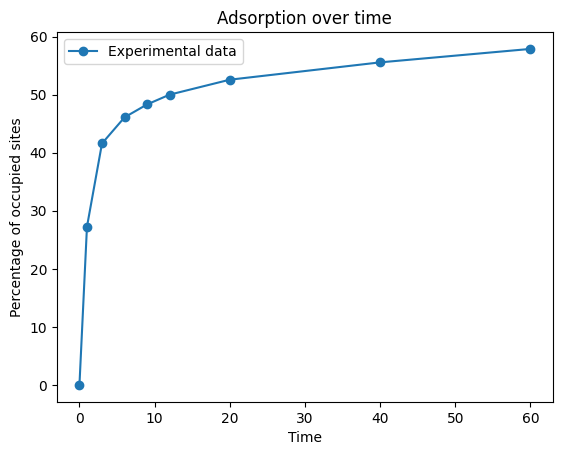

In [4]:
data = pd.read_csv('Datos recogidos.csv')
t = np.array([1,3,6,9,12,20,40,60])

for col in data.columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')

data.dropna(inplace=True)
data.iloc[3] = data.iloc[3] * 10
data.reset_index(drop=True, inplace=True)
data.insert(0, 'T0', 0)


time_array = np.array([0, 1, 3, 6, 9, 12, 20, 40, 60])

plt.plot(time_array, data.iloc[5], marker='o', label='Experimental data')
plt.xlabel("Time")
plt.ylabel("Percentage of occupied sites")
plt.title("Adsorption over time")
plt.legend()
plt.show()

### **Compilación del modelo**

Saturation:  0.0 %
{'adsorption': 4666, 'diffusion': 2127}
Saturation:  53.755102040816325 %


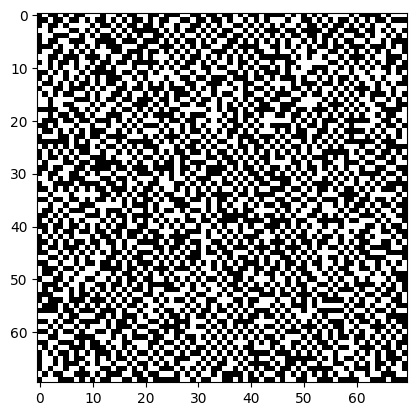

In [5]:
lattice_size = 70
T = 300
e_ads = 0.09
e_diff = 0.294
e_int_abs = 0.1
time_array = np.array([0, 1, 3, 6, 9, 12, 20, 40, 60])
time_factor = 1e-7

KMC = KineticMonteCarlo(lattice_size=lattice_size, T=T, e_ads=e_ads, e_diff=e_diff, e_int_abs=e_int_abs,time_array=time_array, time_factor=time_factor)
print("Saturation: ",np.sum(KMC.lattice)/(lattice_size**2)*100, "%")

occupancy = KMC.run_simulation()
print(KMC.events_count)
print("Saturation: ",np.sum(KMC.lattice)/(lattice_size**2)*100, "%")
plt.imshow(KMC.lattice, cmap='binary')
plt.show()


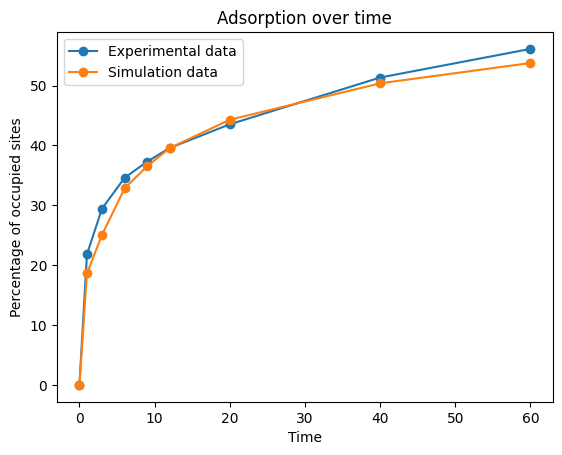

Mean Squared Error (MSE): 4.480543039175618


In [6]:
exp_data = data.iloc[8]
simulated_data = np.array(list(occupancy.values()))
simulated_data[0] = 0


plt.plot(time_array,exp_data,marker='o', label='Experimental data')
plt.plot(time_array,np.array(simulated_data), marker='o', label='Simulation data')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Percentage of occupied sites")
plt.title("Adsorption over time")
plt.show()

mse = np.mean((np.array(exp_data) - np.array(simulated_data)) ** 2)
print(f"Mean Squared Error (MSE): {mse}")

### **Optimización Bayesiana**

In [7]:
base_params = {
    "T": 300,  
    "e_ads": 0.09,  
    "e_diff": 0.294,  
    "e_int_abs": 0.1
}
variability = 0.05

In [8]:
low_e_ads = min(base_params["e_ads"] * (1 - variability), base_params["e_ads"] * (1 + variability))
high_e_ads = max(base_params["e_ads"] * (1 - variability), base_params["e_ads"] * (1 + variability))

low_e_diff = min(base_params["e_diff"] * (1 - variability), base_params["e_diff"] * (1 + variability))
high_e_diff = max(base_params["e_diff"] * (1 - variability), base_params["e_diff"] * (1 + variability))

low_e_int_abs = min(base_params["e_int_abs"] * (1 - variability), base_params["e_int_abs"] * (1 + variability))
high_e_int_abs = max(base_params["e_int_abs"] * (1 - variability), base_params["e_int_abs"] * (1 + variability))

In [9]:
# Definir número de iteraciones
N_CALLS = 200

# Inicializar barra de progreso
progress_bar = tqdm(total=N_CALLS, desc="Optimización Bayesiana en Progreso", position=0)

# Variables para almacenar el mejor resultado
best_params = None
best_error = float("inf")

def loss_function(params):
    global start_time, best_params, best_error
    
    # Desempaquetar parámetros
    e_ads, e_diff, e_int_abs, lattice_size, T = params  

    # Ejecutar el modelo KMC
    kmc_model = KineticMonteCarlo(
        lattice_size=lattice_size, T=T, e_ads=e_ads, 
        e_diff=e_diff, e_int_abs=e_int_abs, time_factor=1e-7,
        time_array=np.array([0, 1, 3, 6, 9, 12, 20, 40, 60])
    )
    kmc_model.run_simulation()

    # Calcular error
    simulated_data = np.array(list(kmc_model.occupancy.values()))
    error = np.mean((simulated_data - exp_data) ** 2)

    # Actualizar mejores parámetros si se encuentra un menor error
    if error < best_error:
        best_error = error
        best_params = params
        print(f"🟢 Nuevo mejor error: {best_error:.6f} con parámetros {best_params}")

    # Calcular tiempos estimados
    elapsed_time = time.time() - start_time
    avg_time_per_iter = elapsed_time / (progress_bar.n + 1)
    estimated_time_left = avg_time_per_iter * (N_CALLS - progress_bar.n - 1)

    # Agregar información en la barra de progreso
    progress_bar.set_postfix({
        "Tiempo transcurrido": f"{elapsed_time:.2f} s",
        "Tiempo restante": f"{estimated_time_left:.2f} s",
        "Mejor error": f"{best_error:.6f}"
    })
    
    progress_bar.update(1)

    return error

# Definir espacio de búsqueda
space = [
    Real(low_e_ads, high_e_ads, name="e_ads"),
    Real(low_e_diff, high_e_diff, name="e_diff"),
    Real(low_e_int_abs, high_e_int_abs, name="e_int_abs"),
    Integer(60, 100, name="lattice_size"),
    Real(280,350, name="T"),
]

# Iniciar optimización
start_time = time.time()
result = gp_minimize(loss_function, space, n_calls=N_CALLS, random_state=42)
progress_bar.close()

# Finalizar optimización
end_time = time.time()
print("\n✅ Optimización completada")
print("🔹 Parámetros óptimos encontrados:", best_params)
print("🔹 Error mínimo encontrado:", best_error)
print(f"⏳ Tiempo total de ejecución: {end_time - start_time:.2f} segundos")


Optimización Bayesiana en Progreso:   0%|          | 0/200 [00:00<?, ?it/s]

🟢 Nuevo mejor error: 1.854138 con parámetros [0.0926688868817421, 0.28469298282206523, 0.1027969100027277, np.int64(84), 311.2082926997514]

Optimización Bayesiana en Progreso:   0%|          | 1/200 [00:00<00:21,  9.09it/s, Tiempo transcurrido=0.11 s, Tiempo restante=21.37 s, Mejor error=1.854138]

Optimización Bayesiana en Progreso:  26%|██▋       | 53/200 [00:19<01:12,  2.01it/s, Tiempo transcurrido=19.69 s, Tiempo restante=54.62 s, Mejor error=1.818399]

🟢 Nuevo mejor error: 1.818399 con parámetros [0.08549999999999999, 0.2793, 0.10285357092160935, np.int64(84), 307.52027505416606]


Optimización Bayesiana en Progreso:  31%|███       | 62/200 [00:24<01:18,  1.75it/s, Tiempo transcurrido=24.88 s, Tiempo restante=55.38 s, Mejor error=1.804615]

🟢 Nuevo mejor error: 1.804615 con parámetros [0.08549999999999999, 0.2793, 0.10176257371280963, np.int64(80), 304.69305305354476]


Optimización Bayesiana en Progreso:  34%|███▎      | 67/200 [00:27<01:20,  1.65it/s, Tiempo transcurrido=27.98 s, Tiempo restante=55.54 s, Mejor error=1.543561]

🟢 Nuevo mejor error: 1.543561 con parámetros [0.08549999999999999, 0.2793, 0.1022601964304004, np.int64(79), 304.59879056257165]


Optimización Bayesiana en Progreso:  36%|███▌      | 71/200 [00:30<01:23,  1.54it/s, Tiempo transcurrido=30.65 s, Tiempo restante=55.68 s, Mejor error=1.507137]

🟢 Nuevo mejor error: 1.507137 con parámetros [0.09318617775151017, 0.30660953520169515, 0.10500000000000001, np.int64(90), 332.8872522516112]


Optimización Bayesiana en Progreso:  36%|███▌      | 72/200 [00:31<01:24,  1.51it/s, Tiempo transcurrido=31.34 s, Tiempo restante=55.72 s, Mejor error=1.189542]

🟢 Nuevo mejor error: 1.189542 con parámetros [0.09323247019103201, 0.3078104795764663, 0.10500000000000001, np.int64(89), 333.03555282999724]


Optimización Bayesiana en Progreso:  42%|████▎     | 85/200 [00:41<01:37,  1.18it/s, Tiempo transcurrido=41.30 s, Tiempo restante=55.87 s, Mejor error=1.132001]

🟢 Nuevo mejor error: 1.132001 con parámetros [0.0945, 0.293493666200793, 0.09856715201913685, np.int64(93), 321.16135465574257]


Optimización Bayesiana en Progreso:  70%|██████▉   | 139/200 [01:46<01:35,  1.56s/it, Tiempo transcurrido=106.38 s, Tiempo restante=46.69 s, Mejor error=0.951518]

🟢 Nuevo mejor error: 0.951518 con parámetros [0.08549999999999999, 0.3017621768677575, 0.10240998902512273, np.int64(89), 320.8843168115234]


Optimización Bayesiana en Progreso:  70%|███████   | 141/200 [01:49<01:33,  1.59s/it, Tiempo transcurrido=109.64 s, Tiempo restante=45.88 s, Mejor error=0.915198]

🟢 Nuevo mejor error: 0.915198 con parámetros [0.08549999999999999, 0.3087, 0.10149507666005995, np.int64(86), 320.82972564579717]


Optimización Bayesiana en Progreso:  72%|███████▎  | 145/200 [01:56<01:33,  1.70s/it, Tiempo transcurrido=116.47 s, Tiempo restante=44.18 s, Mejor error=0.628602]

🟢 Nuevo mejor error: 0.628602 con parámetros [0.08549999999999999, 0.3087, 0.09804241614338507, np.int64(87), 318.6326731941059]


Optimización Bayesiana en Progreso: 100%|██████████| 200/200 [04:05<00:00,  1.23s/it, Tiempo transcurrido=241.96 s, Tiempo restante=0.00 s, Mejor error=0.628602] 


✅ Optimización completada
🔹 Parámetros óptimos encontrados: [0.08549999999999999, 0.3087, 0.09804241614338507, np.int64(87), 318.6326731941059]
🔹 Error mínimo encontrado: 0.6286016325179652
⏳ Tiempo total de ejecución: 245.13 segundos


{'adsorption': 7273, 'diffusion': 2628}
Saturation:  56.163297661514065 %


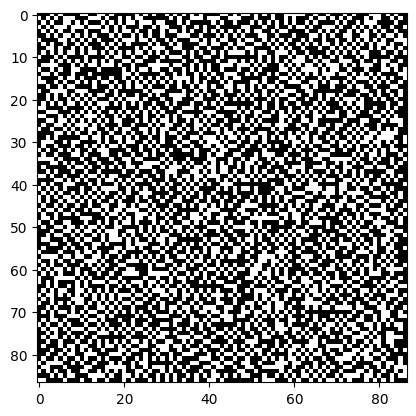

In [12]:
e_ads, e_diff, e_int_abs,lattice_size,T = best_params

kmc_model = KineticMonteCarlo(
    lattice_size= lattice_size, T=T, e_ads=e_ads, 
    e_diff=e_diff, e_int_abs=e_int_abs,time_factor=1e-7,
    time_array = np.array([0, 1, 3, 6, 9, 12, 20, 40, 60]), 
)
occupancy = kmc_model.run_simulation()
print(kmc_model.events_count)
print("Saturation: ",np.sum(kmc_model.lattice)/(lattice_size**2)*100, "%")
plt.imshow(kmc_model.lattice, cmap='binary')
plt.show()

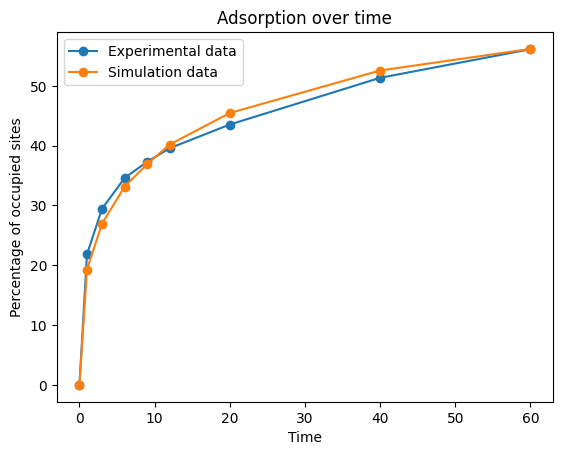

Mean Squared Error (MSE): 2.2701602853209732


In [13]:
simulated_data = np.array(list(occupancy.values()))
simulated_data[0] = 0


plt.plot(time_array,exp_data,marker='o', label='Experimental data')
plt.plot(time_array,np.array(simulated_data), marker='o', label='Simulation data')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Percentage of occupied sites")
plt.title("Adsorption over time")
plt.show()

mse = np.mean((np.array(exp_data) - np.array(simulated_data)) ** 2)
print(f"Mean Squared Error (MSE): {mse}")

### **Repetición hasta minimizar el error**
##### Como se trata de un modelo estocástico, diferentes simulaciones pueden generar diferentes resultados con pequeñas variaciones. Por lo que se compila varias veces el mismo modelo hasta minimizar el error con los datos experimentales.

{'adsorption': 7020, 'diffusion': 2521}
Saturation:  55.15920200819131 %


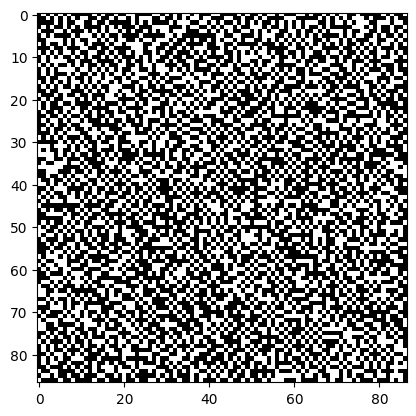

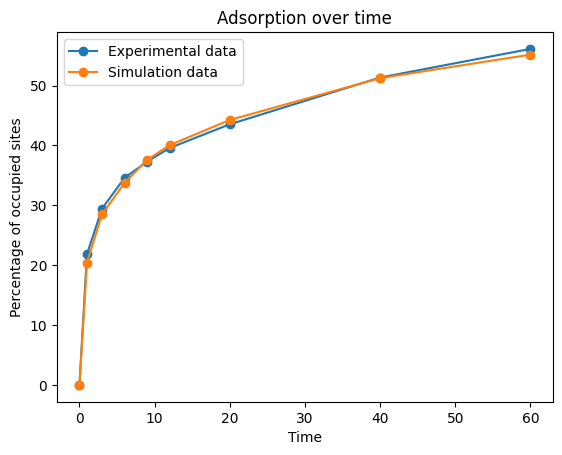

Mean Squared Error (MSE): 0.5925530164510557


In [18]:
while mse >= 0.6:
    e_ads, e_diff, e_int_abs,lattice_size,T = best_params

    kmc_model = KineticMonteCarlo(
        lattice_size= lattice_size, T=T, e_ads=e_ads,
        e_diff=e_diff, e_int_abs=e_int_abs,time_factor=1e-7,
        time_array = np.array([0, 1, 3, 6, 9, 12, 20, 40, 60]), 
    )
    occupancy = kmc_model.run_simulation()

    simulated_data = np.array(list(occupancy.values()))
    simulated_data[0] = 0
    mse = np.mean((np.array(exp_data) - np.array(simulated_data)) ** 2)


print(kmc_model.events_count)
print("Saturation: ",np.sum(kmc_model.lattice)/(lattice_size**2)*100, "%")
plt.imshow(kmc_model.lattice, cmap='binary')
plt.show()

plt.plot(time_array,exp_data,marker='o', label='Experimental data')
plt.plot(time_array,np.array(simulated_data), marker='o', label='Simulation data')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Percentage of occupied sites")
plt.title("Adsorption over time")
plt.show()

mse = np.mean((np.array(exp_data) - np.array(simulated_data)) ** 2)
print(f"Mean Squared Error (MSE): {mse}")

### **Relación Tamaño de Red vs Saturación**

In [ ]:
lattice_sizes = np.arange(60,200,10)
T = 300
e_ads = 0.09
e_diff = 0.294
e_int_abs = 0.1
time_array = np.array([0, 1, 3, 6, 9, 12, 20, 40, 60])
time_factor = 1e-7

saturations = []

for lattice_size in lattice_sizes:
    KMC = KineticMonteCarlo(lattice_size=lattice_size, T=T, e_ads=e_ads, e_diff=e_diff, 
                            e_int_abs=e_int_abs, time_array=time_array, time_factor=time_factor)
    occupancy = KMC.run_simulation()
    simulated_data = np.array(list(occupancy.values()))
    saturation = np.sum(KMC.lattice)/(lattice_size**2)*100
    saturations.append(saturation)

plt.plot(lattice_sizes, saturations, marker='o', linestyle='-', color='b')
plt.xlabel('Lattice Size')
plt.ylabel('Saturación (%)')
plt.title('Saturación vs Lattice Size')
plt.grid(True)
plt.show()